In [34]:
# import modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, make_scorer
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [35]:
# age               : Int
# education         : Categorical
# education level   : Int
# marital status    : Categorical
# Occupation        : Catagorical
# relationship      : Categorical
# race              : Categorical
# sex               : Categorical
# Investment profit : Int, but almost all 0
# Investment loss   : Int, but almost all 0
# hours per week    : Int
# native country    : Categorical
# income            : Conditional (e.g. <=50k, >50k)

In [36]:
df = pd.read_csv('data/survey.csv')
df = df.drop(columns=['Investment profit', 'Investment loss'])

# Encoding
LabelEncoders = {}
for col in df.columns:
    if col not in ['age', 'education level', 'Investment profit', 'Investment loss', 'hours per week']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        LabelEncoders[col] = le

def make_submit(df: pd.DataFrame, file_name: str) -> None:
    submit = pd.DataFrame()
    submit['ID'] = df.index
    submit['Employment Type'] = df['Employment Type']
    submit.to_csv(f'{file_name}.csv', index=False)

# k-means

In [37]:
def find_best_k(df: pd.DataFrame, k_range: range) -> None:
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(df)
        print(f'k={k}, silhouette_score={silhouette_score(df, kmeans.labels_)}')

def learn_kmeans(df: pd.DataFrame, k: int) -> KMeans:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    return kmeans

# find_best_k(df, range(2, 10))
# kmeans = learn_kmeans(df, 5)
# make_submit(kmeans, 'submit_kmeans')

# DBSCANS

In [41]:
from sklearn.neighbors import NearestNeighbors

# scoring = silhouette_score
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)  # Fit and predict cluster labels
    return silhouette_score(X, labels)  # Calculate silhouette score
# Create a scorer for GridSearchCV
scorer = make_scorer(silhouette_scorer, greater_is_better=True)

params = {
    'eps': range(1, 10),
    'min_samples': range(8, 10)
}
grid = GridSearchCV(DBSCAN(), params, scoring=scorer, n_jobs=-1, cv=3)
grid.fit(df)

labels = grid.best_estimator_.fit_predict(df)

# Find the nearest cluster for noise points
noise_points = df[labels == -1]
if not noise_points.empty:
    nearest_neighbors = NearestNeighbors(n_neighbors=1)
    nearest_neighbors.fit(df[labels != -1])
    distances, indices = nearest_neighbors.kneighbors(noise_points)
    nearest_labels = labels[labels != -1][indices.flatten()]
    labels[labels == -1] = nearest_labels

labelsdf = pd.DataFrame(labels, columns=['Employment Type'])


make_submit(labelsdf, 'submit_dbscan')


print(grid.best_params_)
# dbscan = DBSCAN(**grid.best_params_)


c:\Users\carot\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


{'eps': 1, 'min_samples': 8}


# Dimension reduction

NameError: name 'reducted_df' is not defined

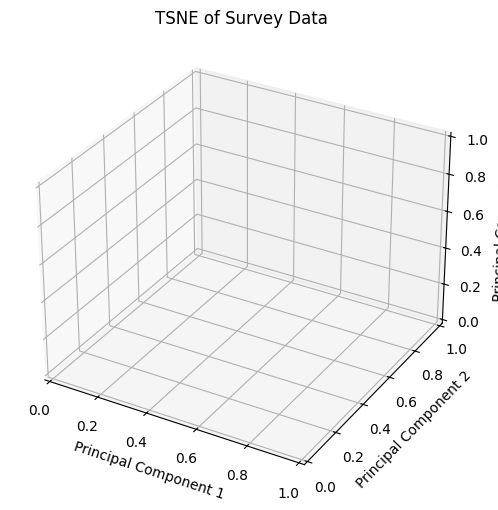

In [39]:
# # Perform PCA or TSNE
# reducted = TSNE(n_components=3)
# principal_components = reducted.fit_transform(df)

# reducted_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

# # 2D Plot
# plt.figure(figsize=(10, 6))
# plt.scatter(reducted_df['PC1'], reducted_df['PC2'], c=kmeans.labels_, cmap='viridis')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('TSNE of Survey Data')
# plt.colorbar(label='Cluster Label')
# plt.show()

# # 3D Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('TSNE of Survey Data')
scatter = ax.scatter(reducted_df['PC1'], reducted_df['PC2'], reducted_df['PC3'], c=dbscan.labels_, cmap='viridis')
fig.colorbar(scatter, label='Cluster Label')
plt.show()